In [1]:
from mobster_mv import mobster_MV
from plot_functions import plot_marginals, plot_deltas, plot_paretos, plot_betas
from create_beta_pareto_dataset import pareto_binomial_component, beta_binomial_component
import numpy as np
import pandas as pd
import pyro.distributions as dist
from scipy.stats import pareto, beta, uniform, norm, lognorm


import torch
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score
import warnings


%load_ext autoreload
%autoreload 2

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### rRACES data

In [2]:
NV_r = pd.read_csv("rRACES_data/NV2.csv")
DP_r = pd.read_csv("rRACES_data/DP2.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([593, 2])
torch.Size([593, 2])


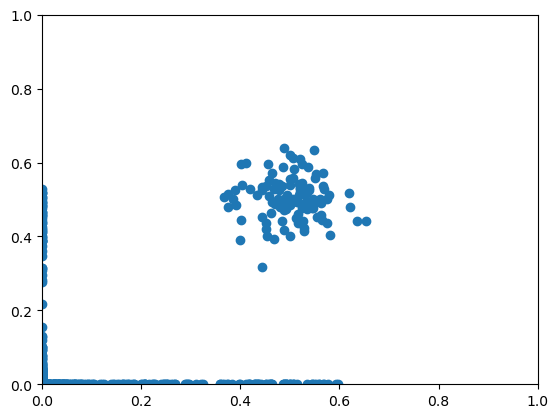

In [3]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

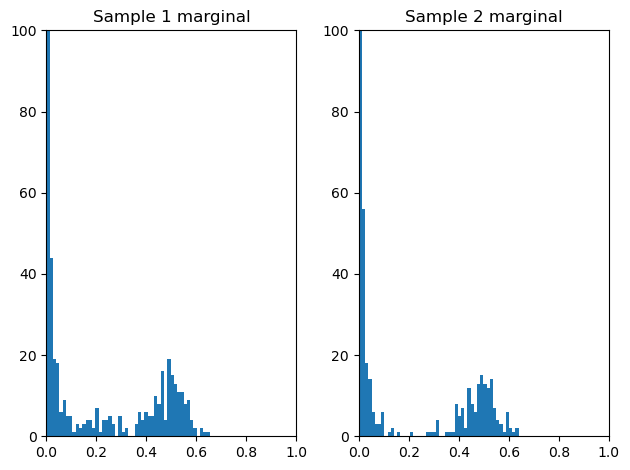

In [4]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 50)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 50)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


kmeans_centers:  tensor([[2.1703e-01, 1.0000e-03],
        [4.9993e-01, 5.0346e-01],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.0000e-03],
        [1.4685e-02, 1.4474e-02]])


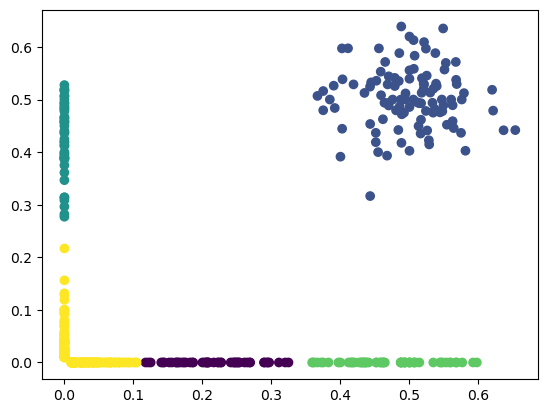

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

c:\Users\Standard\miniconda3\envs\mobsterh\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


kmeans_centers:  tensor([[2.1703e-01, 1.0000e-03],
        [4.9993e-01, 5.0346e-01],
        [2.9802e-08, 4.2671e-01],
        [4.6957e-01, 1.0000e-03],
        [1.4685e-02, 1.4474e-02]])
Iteration 0: Loss = inf


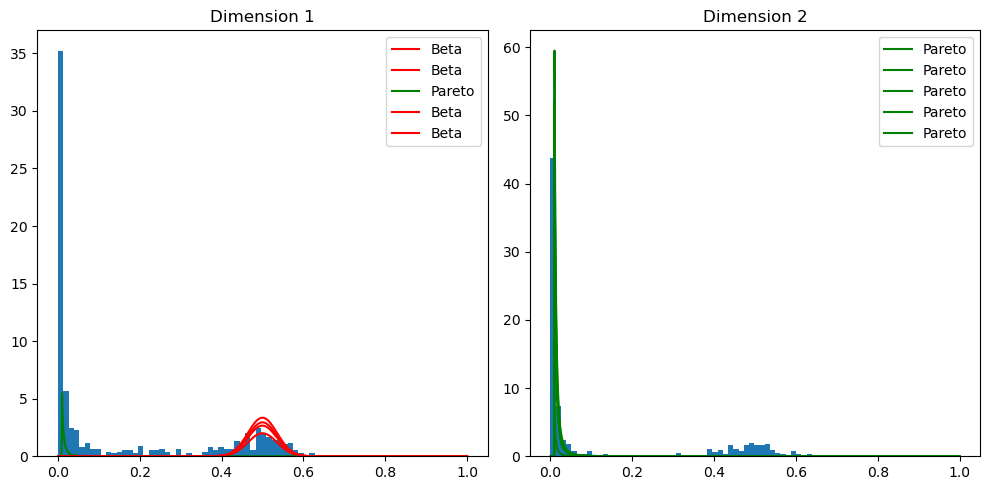

Iteration 200: Loss = -2770472.0
Iteration 400: Loss = -5176430.0
probs_beta [[2.8683034e-01 1.4865786e-03]
 [4.9903324e-01 5.0251210e-01]
 [4.4323482e-08 4.4372496e-01]
 [4.7094658e-01 1.4865786e-03]
 [2.1659248e-02 2.1350158e-02]]


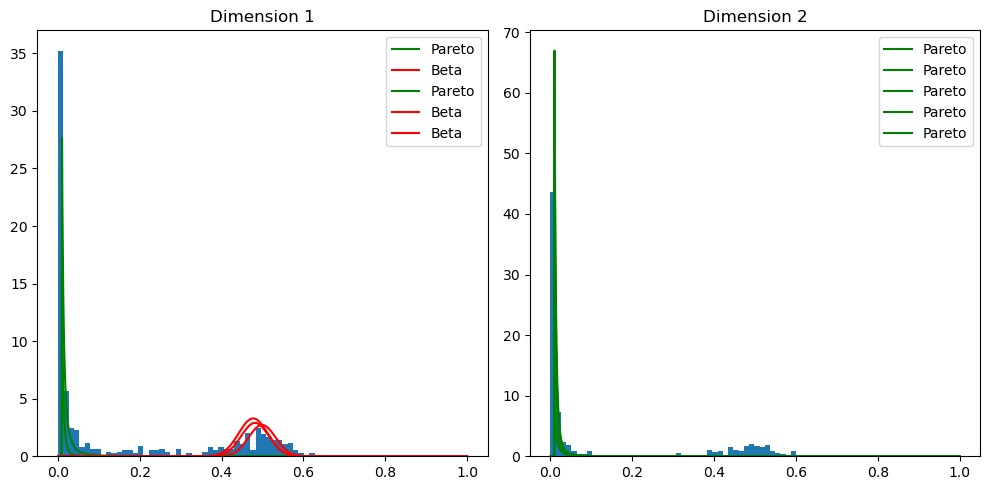

Iteration 600: Loss = -7490680.0
Iteration 800: Loss = -9376491.0
probs_beta [[3.9683905e-01 2.1803954e-03]
 [4.9903187e-01 5.0258791e-01]
 [6.5056113e-08 4.6708763e-01]
 [4.9071625e-01 2.1803954e-03]
 [3.1328063e-02 3.0887606e-02]]


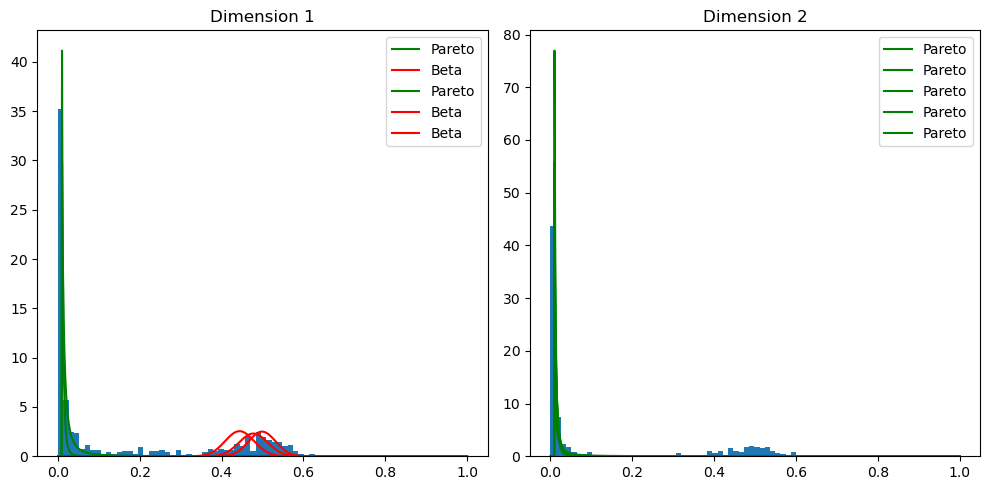

Iteration 1000: Loss = -10986534.0
Iteration 1200: Loss = -12421909.0
probs_beta [[3.9277944e-01 3.1368288e-03]
 [4.9903038e-01 5.0230312e-01]
 [9.3607568e-08 4.6486232e-01]
 [5.0323498e-01 3.1368288e-03]
 [4.4104904e-02 4.3499380e-02]]


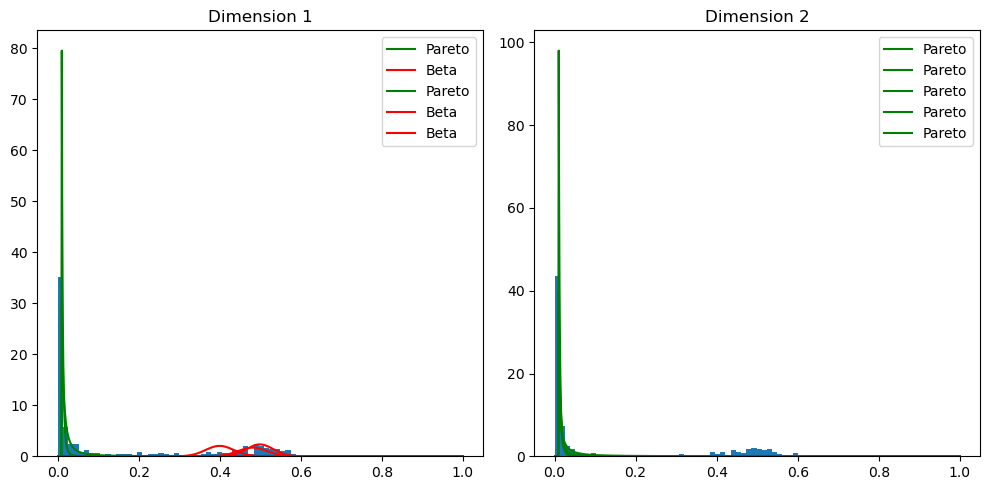

Iteration 1400: Loss = -13712588.0
Iteration 1600: Loss = -14853860.0
probs_beta [[3.9081523e-01 4.3950565e-03]
 [4.9903139e-01 5.0212914e-01]
 [1.3093532e-07 4.5989308e-01]
 [5.0347126e-01 4.3950565e-03]
 [5.9917107e-02 5.9122562e-02]]


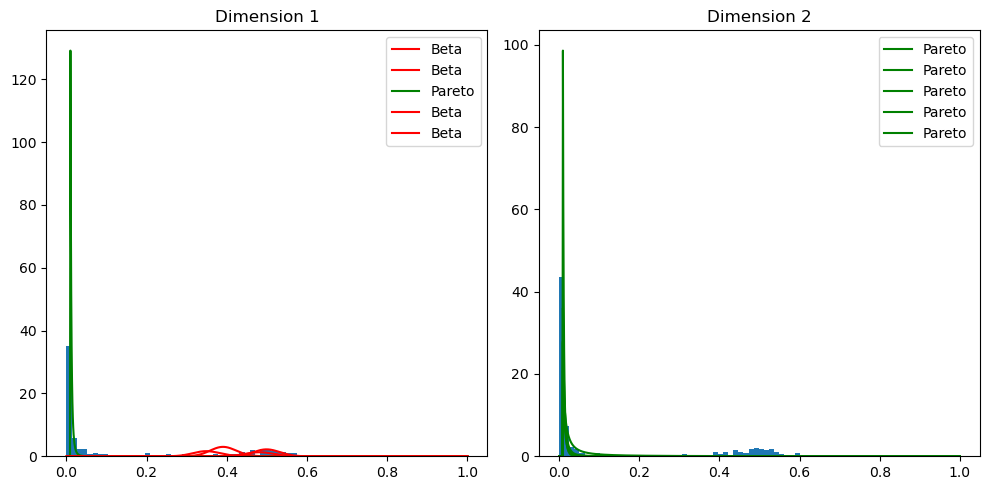

Iteration 1800: Loss = -15876931.0
Iteration 2000: Loss = -16811098.0
probs_beta [[3.8800272e-01 5.9714755e-03]
 [4.9902654e-01 5.0203222e-01]
 [1.7707136e-07 4.5385495e-01]
 [5.0343055e-01 5.9714755e-03]
 [7.8064367e-02 7.7078260e-02]]


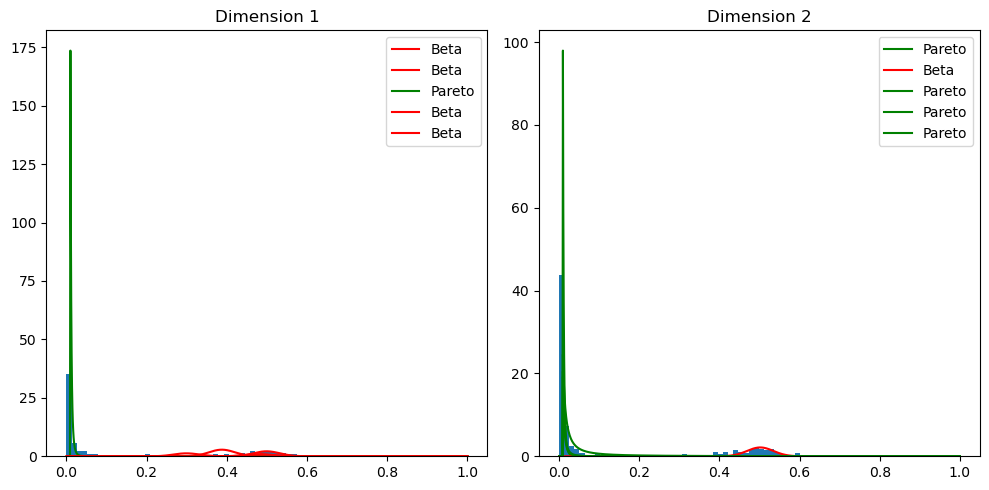

Iteration 2200: Loss = -17666886.0
Iteration 2400: Loss = -18453774.0
probs_beta [[3.8681537e-01 7.8693135e-03]
 [4.9902427e-01 5.0197792e-01]
 [2.3149960e-07 4.4626921e-01]
 [5.0337428e-01 7.8693135e-03]
 [9.7306304e-02 9.6154578e-02]]


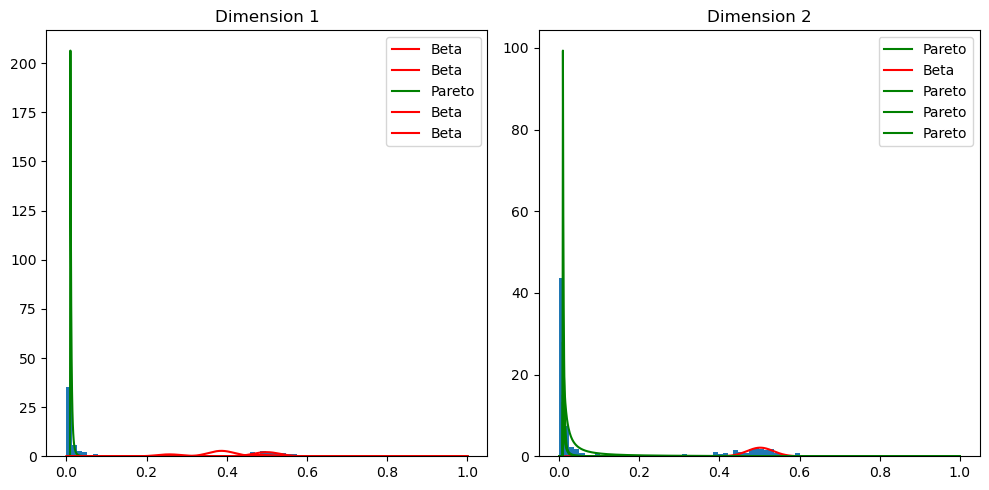

Iteration 2600: Loss = -19183924.0
Iteration 2800: Loss = -19867142.0
probs_beta [[3.8626125e-01 1.0094217e-02]
 [4.9902877e-01 5.0194561e-01]
 [2.9381545e-07 4.3757433e-01]
 [5.0330424e-01 1.0094217e-02]
 [1.1608877e-01 1.1482591e-01]]


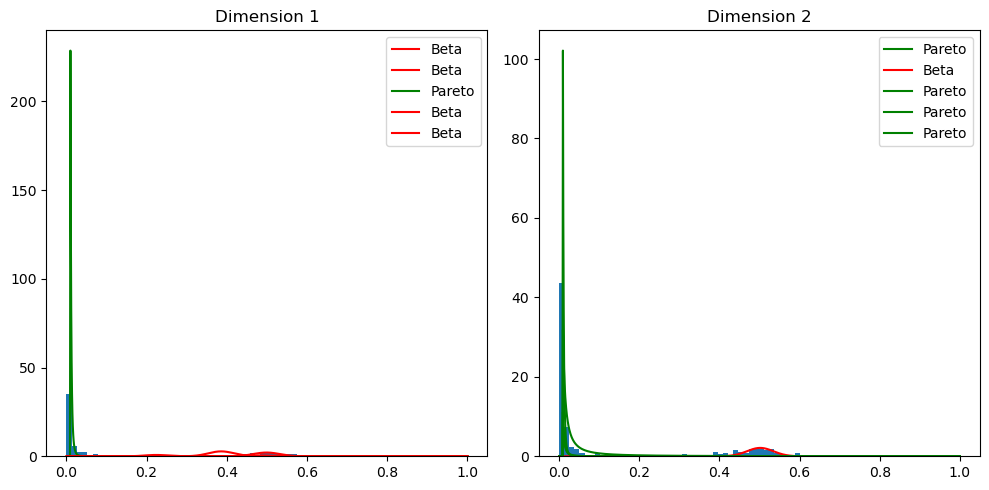

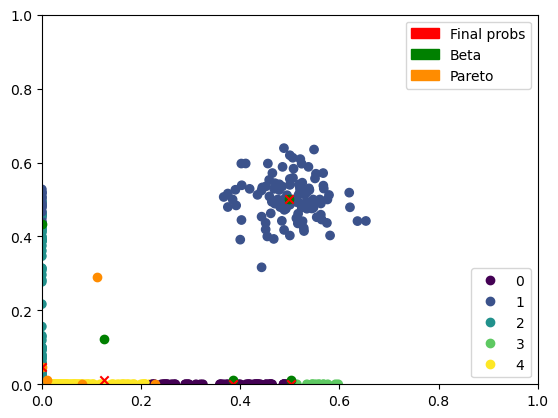

In [11]:
mb = mobster_MV(NV, DP, K = 5, seed = 123)
mb.fit(num_iter = 10000, lr = 0.001)

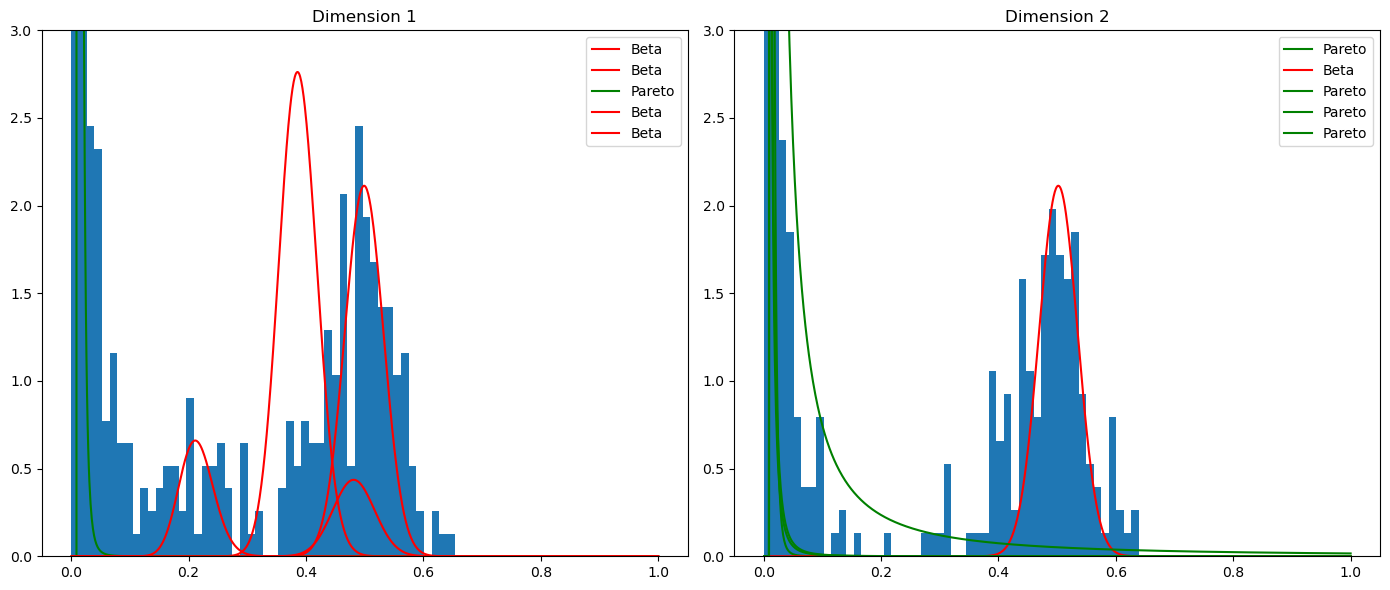

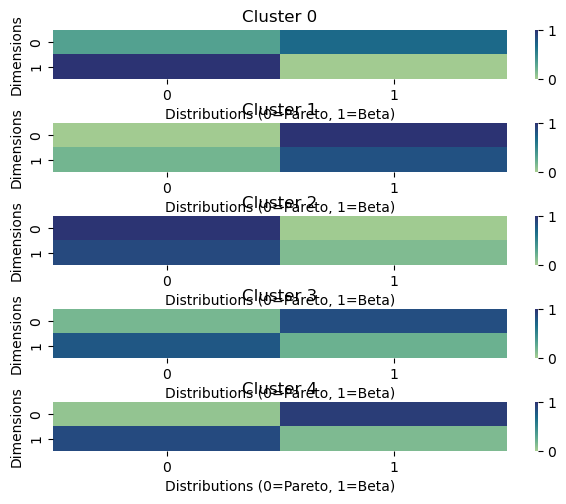

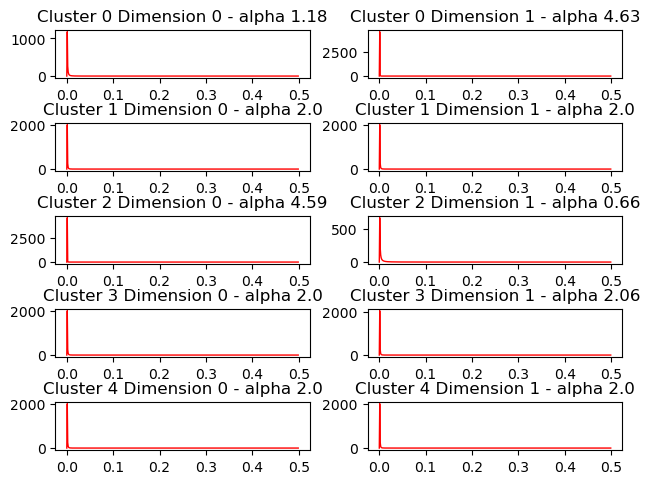

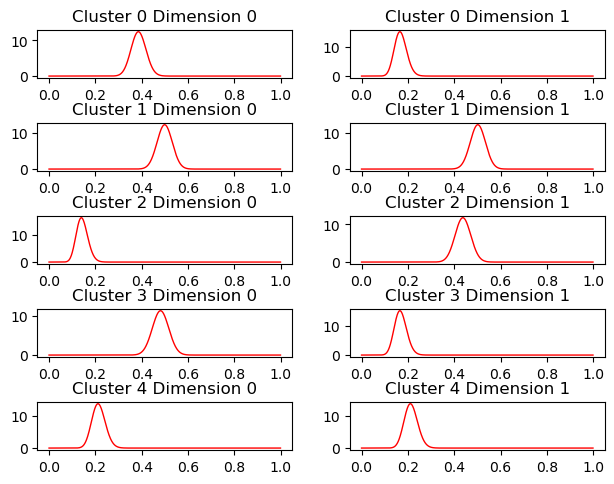

In [12]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [13]:
mb.params

{'probs_beta': tensor([[3.8605e-01, 1.1327e-02],
         [4.9903e-01, 5.0193e-01],
         [3.2775e-07, 4.3371e-01],
         [5.0326e-01, 1.1327e-02],
         [1.2476e-01, 1.2347e-01]]),
 'probs_pareto': tensor([[8.1959e-02, 2.8113e-05],
         [1.1138e-01, 2.9056e-01],
         [8.2243e-10, 4.7646e-02],
         [2.2888e-01, 4.7522e-04],
         [1.1162e-02, 1.0711e-02]]),
 'weights': tensor([0.2227, 0.1736, 0.5172, 0.0387, 0.0479]),
 'delta': tensor([[[0.3168, 0.6832],
          [0.9869, 0.0131]],
 
         [[0.0126, 0.9874],
          [0.1790, 0.8210]],
 
         [[0.9834, 0.0166],
          [0.8674, 0.1326]],
 
         [[0.1614, 0.8386],
          [0.7911, 0.2089]],
 
         [[0.0647, 0.9353],
          [0.8620, 0.1380]]]),
 'alpha_pareto': tensor([[1.1780, 4.6334],
         [1.9999, 1.9985],
         [4.5897, 0.6628],
         [1.9999, 2.0615],
         [2.0000, 2.0000]]),
 'phi_beta': tensor([[0.3866, 0.1689],
         [0.4990, 0.5019],
         [0.1431, 0.4379],
    

### rRACES longitudinal data

In [3]:
NV_r = pd.read_csv("rRACES_data/NV_long.csv")
DP_r = pd.read_csv("rRACES_data/DP_long.csv")

NV = torch.tensor(NV_r.to_numpy())
DP = torch.tensor(DP_r.to_numpy())

print(NV.shape)
print(DP.shape)

torch.Size([1224, 2])
torch.Size([1224, 2])


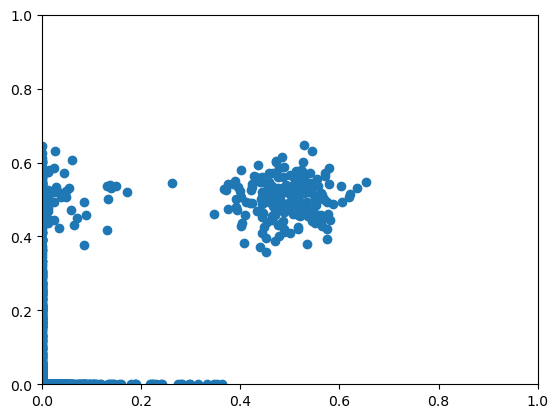

In [11]:
# Plot the dataset
plt.xlim([0,1])
plt.ylim([0,1])
plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1])

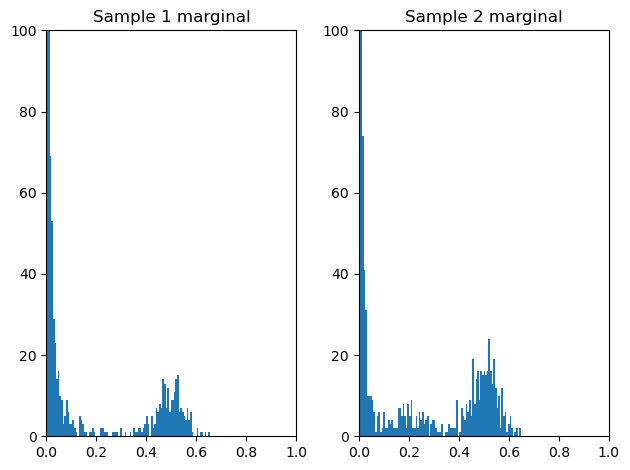

In [12]:
# plt.figure(figsize=(10, 5))

# First subplot for Sample 1 marginal
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# Plot marginal of S1
plt.hist(NV[:,0].numpy()/DP[:,0].numpy(), bins = 100)
plt.title("Sample 1 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Second subplot for Sample 2 marginal
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(NV[:,1].numpy()/DP[:,1].numpy(), bins = 100)
plt.title("Sample 2 marginal")
plt.xlim([0,1])
plt.ylim([0,100])

# Display the plots
plt.tight_layout()
plt.show()

kmeans_centers:  tensor([[1.4442e-02, 1.1785e-02],
        [4.9358e-01, 5.0280e-01],
        [1.6109e-02, 4.9525e-01],
        [2.2913e-01, 1.0000e-03],
        [2.2352e-08, 2.1557e-01]])


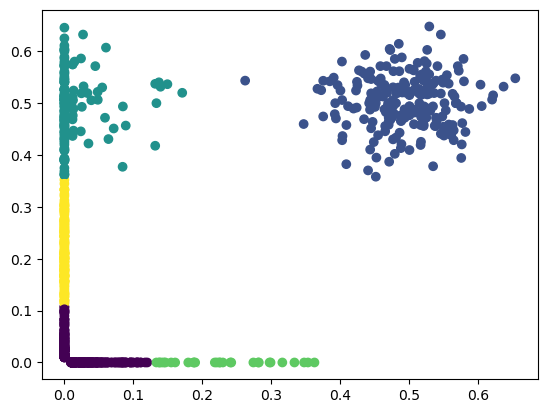

In [9]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=123, n_init="auto").fit((NV/DP).numpy())
cluster = kmeans.labels_
centers = torch.tensor(kmeans.cluster_centers_)
centers[centers <= 0] = 0.001
centers[centers >= 1] = 0.999

print("kmeans_centers: ", centers)

sc = plt.scatter(NV[:,0]/DP[:,0], NV[:,1]/DP[:,1], c = cluster)

kmeans_centers:  tensor([[1.4293e-02, 1.1802e-02],
        [4.4452e-01, 4.9081e-01],
        [1.6109e-02, 4.9525e-01],
        [5.3156e-01, 5.1208e-01],
        [2.2352e-08, 2.1557e-01],
        [2.2550e-01, 1.0000e-03]])
Iteration 0: Loss = -24529224.0
weights_param tensor([0.2276, 0.0795, 0.1792, 0.0410, 0.1885, 0.2842],
       grad_fn=<DivBackward0>)
delta_param tensor([[[0.9184, 0.0816],
         [0.3531, 0.6469]],

        [[0.0823, 0.9177],
         [0.6616, 0.3384]],

        [[0.5781, 0.4219],
         [0.1022, 0.8978]],

        [[0.0463, 0.9537],
         [0.1371, 0.8629]],

        [[0.6231, 0.3769],
         [0.7587, 0.2413]],

        [[0.1220, 0.8780],
         [0.1700, 0.8300]]], grad_fn=<DivBackward0>)
alpha_param tensor([[2.0020, 2.0020],
        [1.9980, 1.9980],
        [2.0020, 1.9980],
        [1.9980, 1.9980],
        [2.0020, 1.9980],
        [1.9980, 2.0020]], grad_fn=<AddBackward0>)
phi_beta_param tensor([[1.4307e-02, 1.1813e-02],
        [4.4477e-01, 4.9106e-0

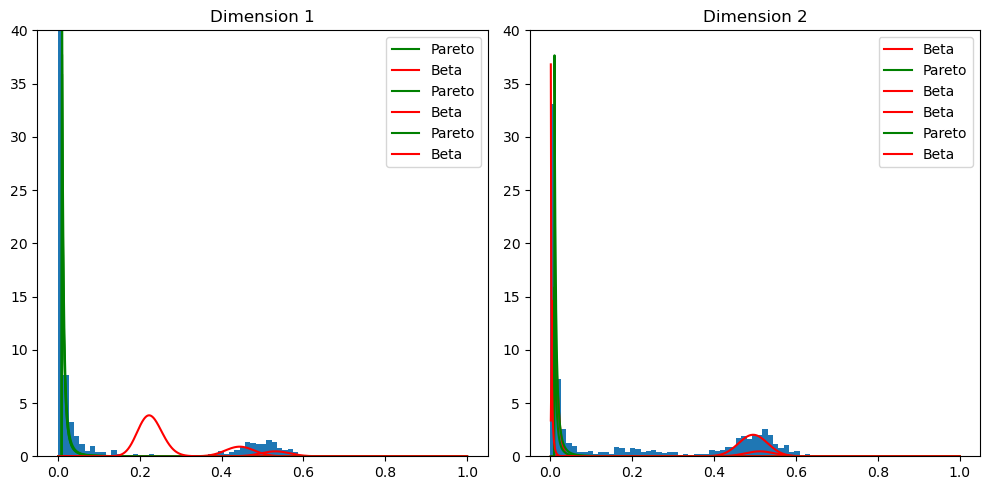

Iteration 200: Loss = -34584076.0
Iteration 400: Loss = -49164044.0
probs_beta [[1.6920123e-02 1.0390854e-02]
 [4.7473440e-01 5.0363421e-01]
 [2.5625050e-02 5.0834894e-01]
 [5.0074530e-01 5.0243366e-01]
 [1.4971143e-08 1.7827612e-01]
 [1.6071279e-01 8.5731060e-04]]


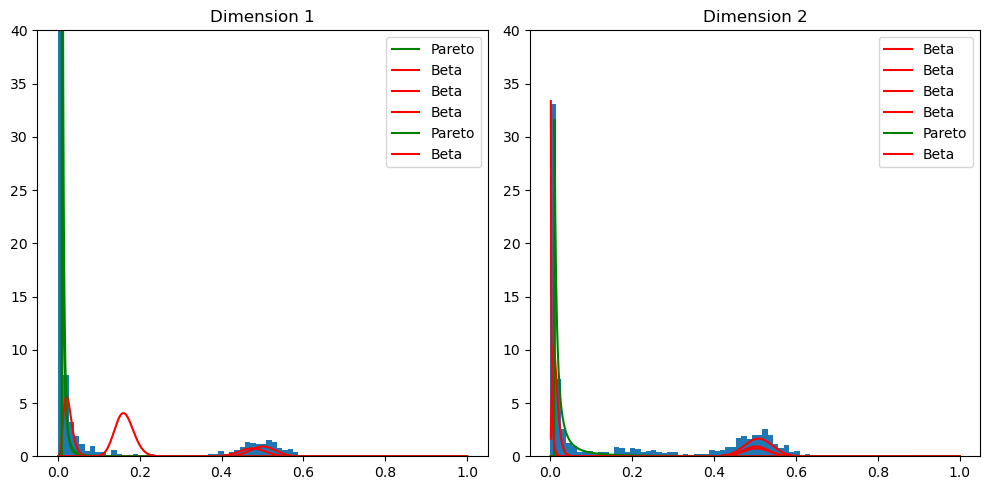

Iteration 600: Loss = -68274584.0
Iteration 800: Loss = -94365128.0
probs_beta [[1.6916102e-02 1.0390829e-02]
 [4.6434379e-01 5.0397438e-01]
 [3.7892185e-02 5.0589174e-01]
 [4.9779552e-01 5.0257790e-01]
 [1.0037662e-08 2.2422996e-01]
 [1.4726944e-01 8.5277949e-04]]


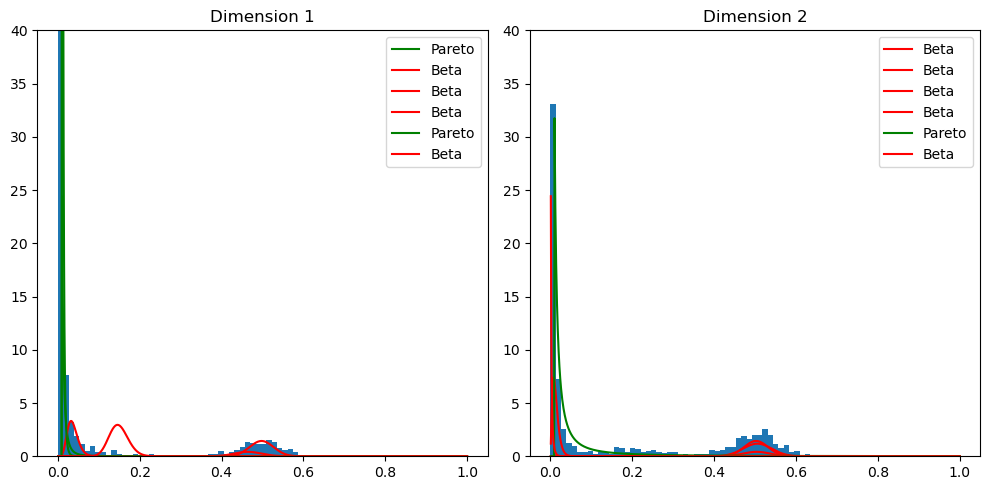

Iteration 1000: Loss = -132162168.0
Iteration 1200: Loss = -189460112.0
probs_beta [[1.6909759e-02 1.0390829e-02]
 [4.2554614e-01 5.0855523e-01]
 [4.7485214e-02 5.2504748e-01]
 [4.9786440e-01 5.0232226e-01]
 [6.7299242e-09 2.7345502e-01]
 [1.6413239e-01 8.4704219e-04]]


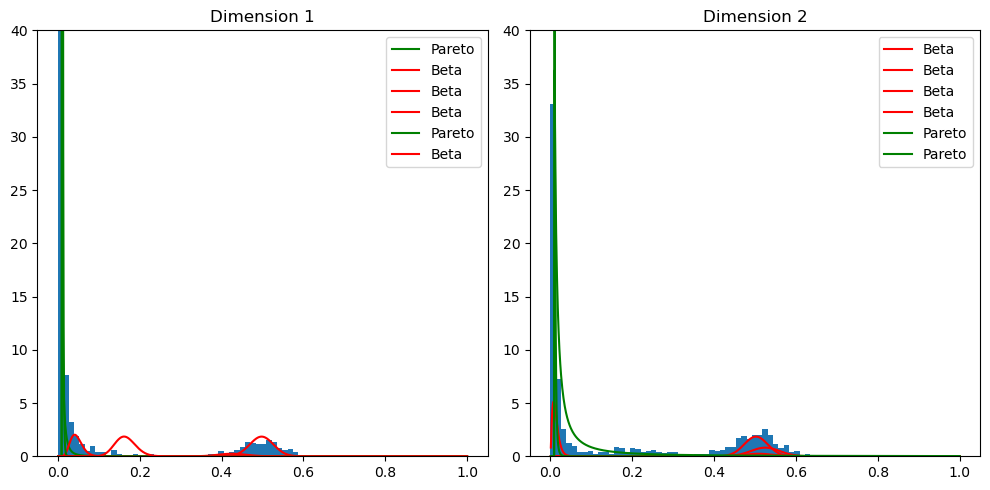

Iteration 1400: Loss = -277151168.0
Iteration 1600: Loss = -412776672.0
probs_beta [[1.6900480e-02 1.0390829e-02]
 [4.2113820e-01 5.0077093e-01]
 [4.7845855e-02 5.2401984e-01]
 [4.9730015e-01 5.0264180e-01]
 [4.5121946e-09 3.1565362e-01]
 [1.9022575e-01 8.3947752e-04]]


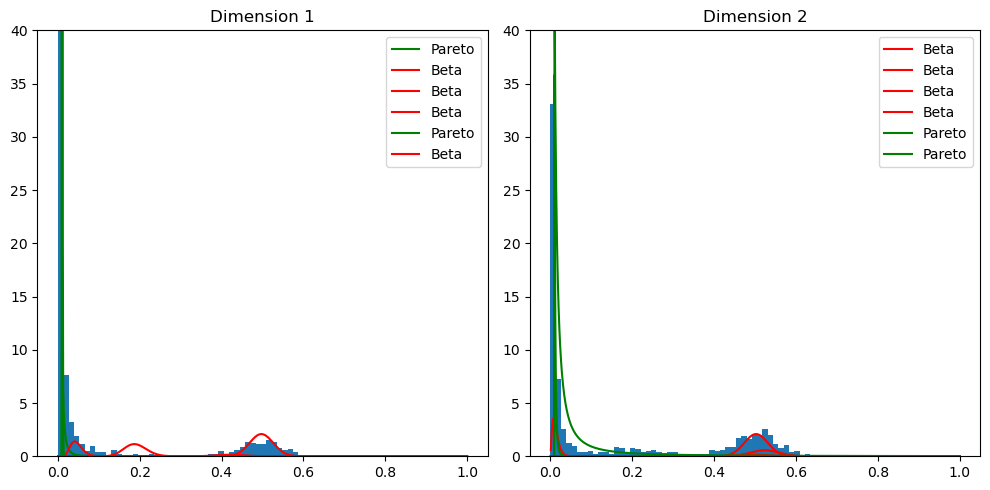

Iteration 1800: Loss = -632634752.0
Iteration 2000: Loss = -1070410880.0
probs_beta [[1.6889028e-02 1.0390829e-02]
 [4.8536578e-01 5.0473708e-01]
 [4.7845855e-02 5.2402055e-01]
 [5.6383437e-01 4.9330544e-01]
 [3.0252791e-09 3.8070360e-01]
 [1.9357386e-01 8.2989316e-04]]


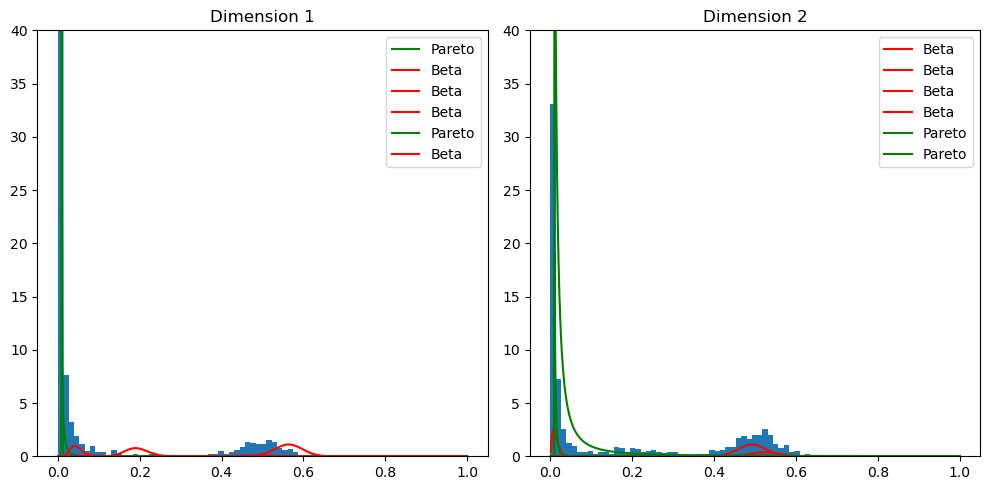

Iteration 2200: Loss = -1756034176.0
Iteration 2400: Loss = -2739594752.0
probs_beta [[1.6874734e-02 1.0390829e-02]
 [4.8538083e-01 5.0474972e-01]
 [4.7845855e-02 5.2402174e-01]
 [5.6393123e-01 4.9352992e-01]
 [2.0283510e-09 4.2472512e-01]
 [1.9357386e-01 8.1803341e-04]]


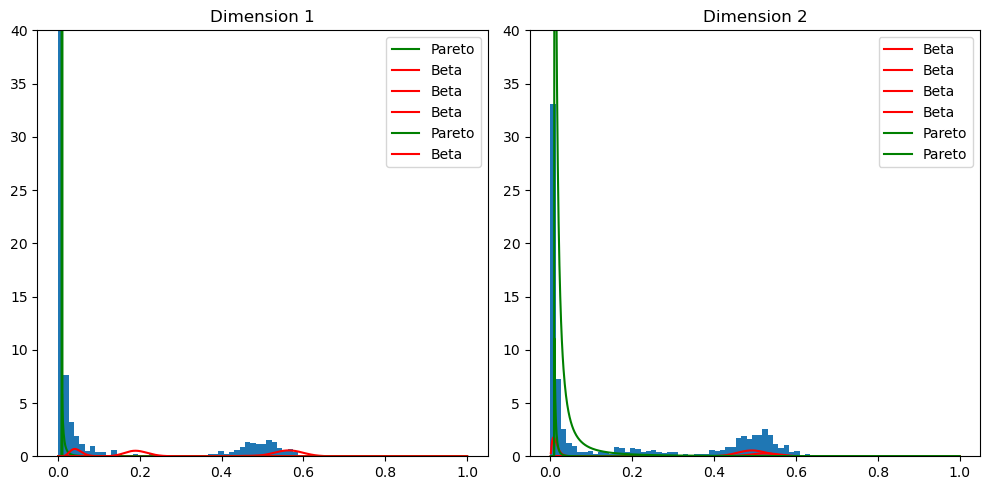

Iteration 2600: Loss = -4083778304.0
Iteration 2800: Loss = -5760763392.0
probs_beta [[1.6857071e-02 1.0390829e-02]
 [4.8537281e-01 5.0474948e-01]
 [4.7845855e-02 5.2402318e-01]
 [5.6393123e-01 4.9352145e-01]
 [1.3599432e-09 4.3123281e-01]
 [1.9357386e-01 8.0359878e-04]]


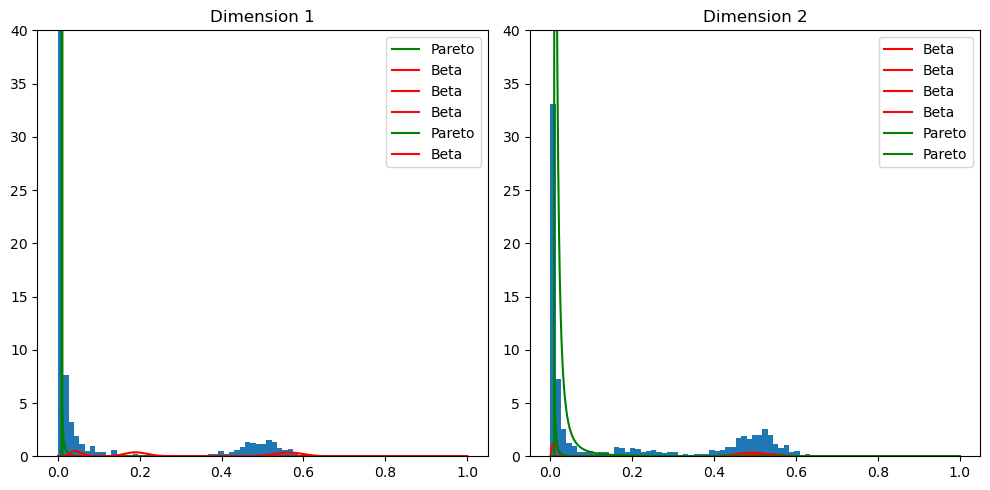

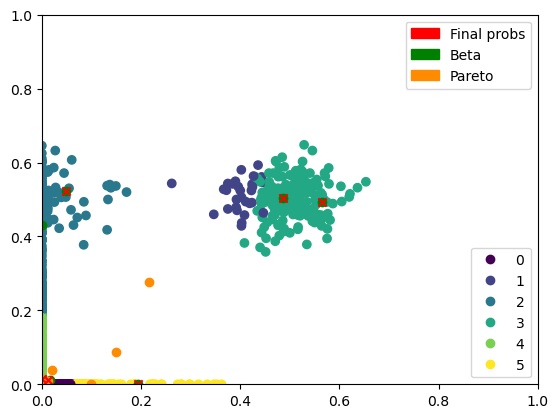

In [14]:
mb = mobster_MV(NV, DP, K = 6, seed = 25)
mb.fit(num_iter = 3000, lr = 0.001)

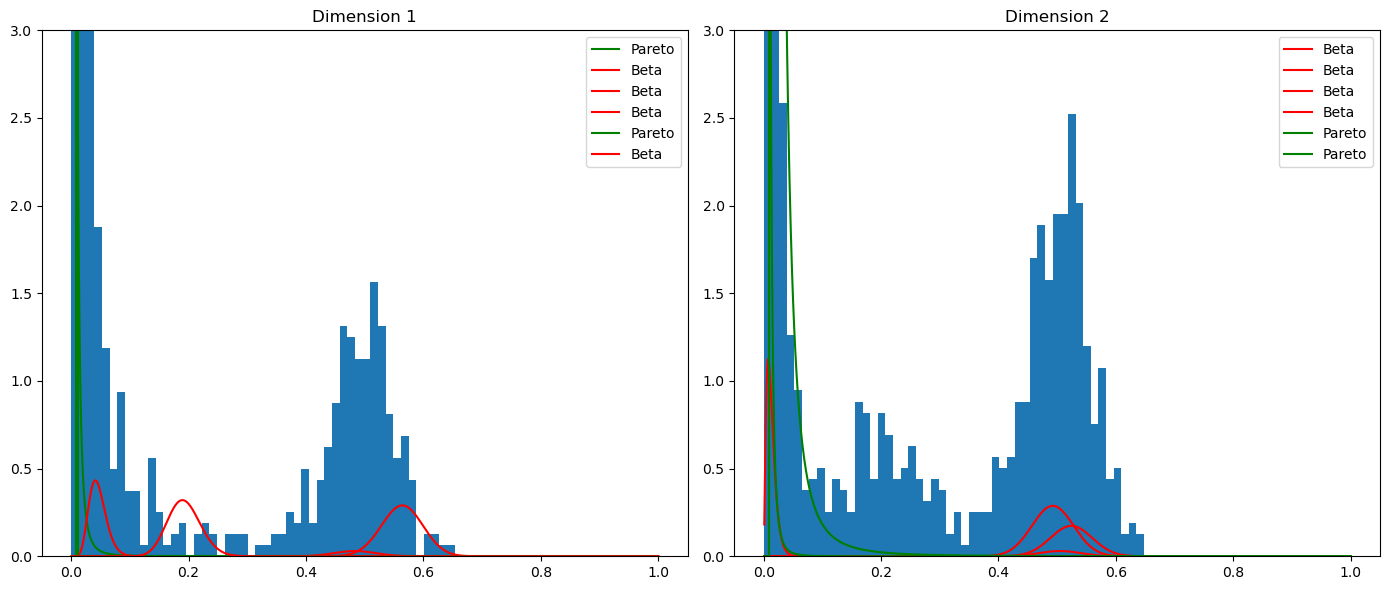

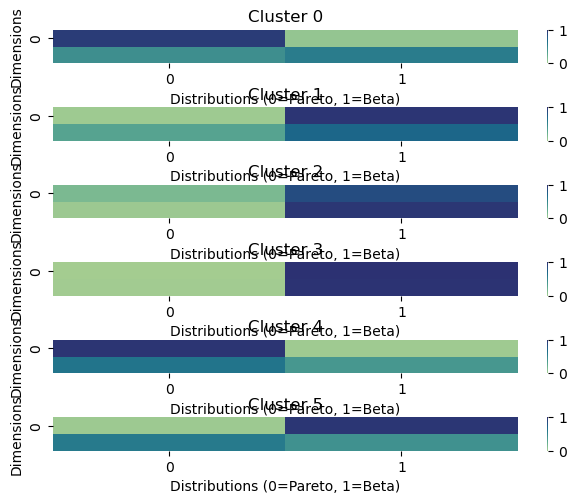

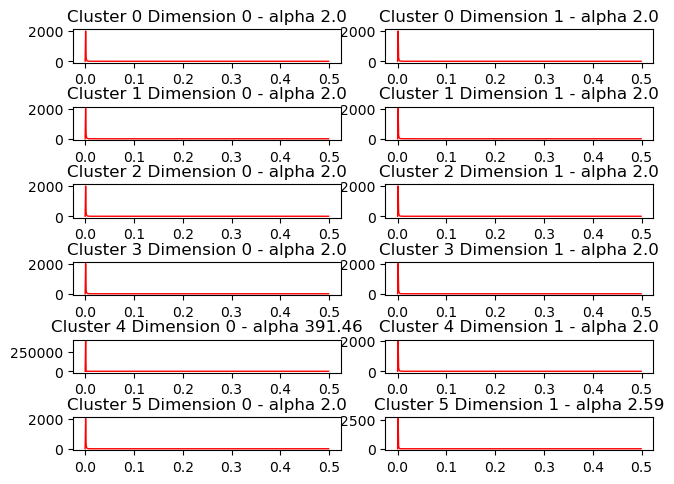

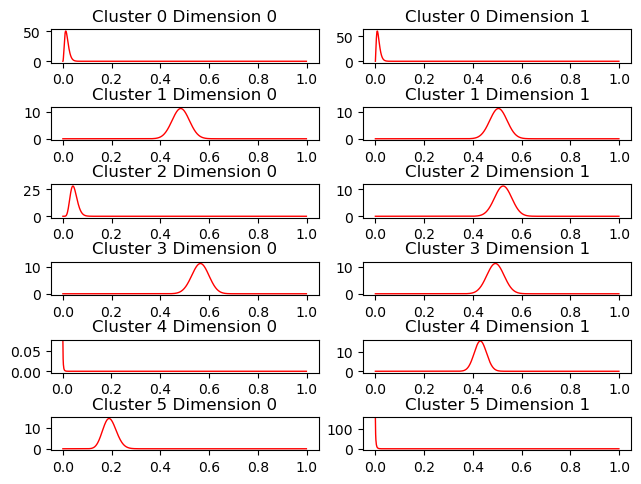

In [15]:
plot_marginals(mb)
plot_deltas(mb)
plot_paretos(mb)
plot_betas(mb)

In [ ]:
# Without small gaussian noise
mb.params

{'probs_beta': tensor([[7.7406e-05, 6.5332e-05],
         [2.5845e-01, 5.4217e-01],
         [1.4242e-01, 5.2738e-01],
         [4.9478e-01, 5.0872e-01],
         [1.5102e-10, 4.8774e-01],
         [1.6578e-02, 1.1755e-38]]),
 'probs_pareto': tensor([[9.6864e-05, 7.9918e-05],
         [2.1404e-01, 9.5336e-02],
         [2.1434e-02, 4.6711e-03],
         [1.4626e-01, 1.0926e-02],
         [1.3004e-10, 2.9232e-01],
         [3.5158e-01, 1.1755e-38]]),
 'weights': tensor([0.0067, 0.0009, 0.0069, 0.1590, 0.1035, 0.7231]),
 'delta': tensor([[[9.1828e-01, 8.1717e-02],
          [3.5268e-01, 6.4732e-01]],
 
         [[1.9263e-02, 9.8074e-01],
          [2.4015e-01, 7.5985e-01]],
 
         [[1.3247e-02, 9.8675e-01],
          [4.4010e-03, 9.9560e-01]],
 
         [[6.1669e-04, 9.9938e-01],
          [1.9492e-03, 9.9805e-01]],
 
         [[9.8935e-01, 1.0648e-02],
          [3.0956e-02, 9.6904e-01]],
 
         [[5.0354e-02, 9.4965e-01],
          [9.7256e-01, 2.7444e-02]]]),
 'alpha_pareto': 